In [1]:
from scipy.optimize import linprog
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Entity():
    def __init__(self, 
                 power_prod       = [0.0],     # 1 Power unit producing, 
                 power_cons       = [0.0],     # 1 Power unit consuming
                 power_type       = 0,         # Default consumer
                 eff_prod         = [1.0],     # Efficiency producing, Efficiency consuming, if efficieny is 0.5 it needs 2 unit stored in for 1 unit to node
                 eff_cons         = [1.0],
                 storage_capacity = 0,         # maximum storage capacity
                 start_capacity   = 0,         # start capacity
                 name             = "",        # name displayed in plots
                 cost_prod        = [0.0],     # price per 1 power unit producing
                 cost_cons        = [0.0],     # price per 1 power unit consuming (aka, selling)
                 color            = "blue"):   # color in plots
        
        self.power_prod       = power_prod
        self.power_cons       = power_cons
        self.power_type       = power_type
        self.eff_prod         = eff_prod
        self.eff_cons         = eff_cons
        self.storage_capacity = storage_capacity
        self.start_capacity   = start_capacity 
        self.name             = name
        self.cost_prod        = cost_prod
        self.cost_cons        = cost_cons
        self.A_ub             = None
        self.b_ub             = np.array([start_capacity, storage_capacity-start_capacity])
        self.color            = color
        
        
        
    def get_cost_fun_vec(self,t):
        # Get the cost function vector for the minimization
        return np.array([self.cost_prod[t % len(self.cost_prod)]*self.power_prod[t % len(self.power_prod)], 
                         self.cost_cons[t % len(self.cost_cons)]*self.power_cons[t % len(self.power_cons)]])
    
    def get_zero_columns(self):
        # some columns have only 0 entries
        # Consumer
        if self.power_type == 0:
            return  np.array([False, True])
        # Producer
        elif self.power_type == 1:
            return np.array([True, False])
        # Storage
        elif self.power_type == 2:
            return np.array([True, True])
        # Grid
        elif self.power_type == 3:
            return np.array([True, True])
    
    def get_node_vec(self,t):
        # Consumer
        if self.power_type == 0:
            return  np.array([0, -1.0/self.eff_cons[t % len(self.eff_cons)]*self.power_cons[t % len(self.power_cons)]])
        # Producer
        elif self.power_type == 1:
            return np.array([self.eff_prod[t % len(self.eff_prod)]*self.power_prod[t % len(self.power_prod)], 0])
        # Storage
        elif self.power_type == 2:
            return np.array([self.power_prod[t % len(self.power_prod)], 
                             -1.0/self.eff_cons[t % len(self.eff_cons)]*self.power_cons[t % len(self.power_cons)]])
        elif self.power_type == 3:
            return np.array([self.power_prod[t % len(self.power_prod)], 
                             -1.0/self.eff_cons[t % len(self.eff_cons)]*self.power_cons[t % len(self.power_cons)]])
        
    def get_consumer_vec(self,t):
        # 1 or 0 define if consumed column or produced column
        if self.power_type==0:
            return (True, -self.eff_cons[t % len(self.eff_cons)]*self.power_cons[t % len(self.power_cons)], 1)
        if self.power_type==1:
            return (True, self.eff_prod[t % len(self.eff_prod)]*self.power_prod[t % len(self.power_prod)], 0)
        else:
            return (False, None, 0)
        
    # Create matrix entries so that the storage cannot be less than 0 and not larger than storage maximum
    def get_storage_eq(self,size,index,t):
        if self.power_type==2:
            if self.A_ub is None:
                self.A_ub = np.zeros((2,size))
                self.A_ub[0,index:index+2] = np.array([1.0/self.eff_prod[t % len(self.eff_prod)]*self.power_prod[t % len(self.power_prod)], 
                                                        -self.power_cons[t % len(self.power_cons)]])
                self.A_ub[1,index:index+2] = np.array([-1.0/self.eff_prod[t % len(self.eff_prod)]*self.power_prod[t % len(self.power_prod)], 
                                                        self.power_cons[t % len(self.power_cons)]])
            else:
                self.A_ub[0,index:index+2] = np.array([1.0/self.eff_prod[t % len(self.eff_prod)]*self.power_prod[t % len(self.power_prod)], 
                                                        -self.power_cons[t % len(self.power_cons)]])
                self.A_ub[1,index:index+2] = np.array([-1.0/self.eff_prod[t % len(self.eff_prod)]*self.power_prod[t % len(self.power_prod)], 
                                                        self.power_cons[t % len(self.power_cons)]])
                
            return (True, self.A_ub, self.b_ub)
        else:
            return (False, None, None)
        
        
    def get_power_vec(self,t):
        return [self.power_prod[t % len(self.power_prod)], 
                -1.0/self.eff_cons[t % len(self.eff_cons)]*self.power_cons[t % len(self.power_cons)]]
    
    def get_color_vec(self):
        return [self.color, self.color]
        
        
    def get_variable_names(self, time):
        return [f"{self.name}\n-\nt={time}", f"{self.name}\n+\nt={time}"]
    

In [ ]:
entities = [Entity(name="Lake", power_type= 2,
                   power_cons = [2.0], 
                   eff_cons   = [0.8],
                   cost_cons  = [0],
                   
                   power_prod = [2.0], 
                   eff_prod   = [1.0],
                   cost_prod  = [0],
                   storage_capacity = 20.0,
                   start_capacity   = 0.0,
                   color="green"),
            
            Entity(name="Grid", power_type=3,
                   power_cons = [4.0], power_prod = [4.0], 
                   eff_cons   = [1.0], eff_prod   = [1.0],
                   cost_cons  = [0]  , cost_prod  = [1,2],
                   color="red"),
            
            Entity(name="City",power_type=0,
                   power_cons = [1.0, 1.0, 2.0, 2.0], 
                   eff_cons   = [1.0], 
                   cost_cons  = [0]  , 
                   color="blue")]

# How many time steps
time_steps = 4

# Currently A_eq and b_eq are only for Kirchhoffs Law
A_eq =  np.zeros((time_steps,2*time_steps*(len(entities))))
b_eq = np.zeros(time_steps)
c = np.zeros(2*len(entities)*time_steps)

power_vec = np.zeros(2*len(entities)*time_steps)

A_ub = None
b_ub = None

# Probably not so efficient
column_names = np.empty(2*len(entities)*time_steps,dtype=object)

colors = np.empty(2*len(entities)*time_steps,dtype=object)
    
# Needed for interior point
# linprog starts in middle of lb and ub -> 0.5  with that we can multiply the result to pull all unused variables to 0
non_zero_columns = np.zeros(2*len(entities)*time_steps) 

for idx, x in enumerate(entities):
    for t in range(0,time_steps):
        index = 2*(t*len(entities)+idx)
        
        column_names[index:index+2] =  x.get_variable_names(t) # column names
        
        colors[index:index+2] =  x.get_color_vec() # column names
        
        power_vec[index:index+2] = x.get_power_vec(t)
        
        c[index:index+2] = x.get_cost_fun_vec(t) # cost vector
        
        non_zero_columns[index:index+2] = x.get_zero_columns()
        
        A_eq[t,index:index+2] = x.get_node_vec(t) # Kirchhoffs Law
        
        # Consumers must be satisfied!
        # As well as producers
        cond, value, i = x.get_consumer_vec(t)
        if cond:
            cache = np.zeros(2*len(entities)*time_steps)
            cache[index+i] = value
            A_eq = np.vstack([A_eq,cache])
            b_eq = np.hstack([b_eq, value])
            
        cond, cA_ub, cb_ub = x.get_storage_eq(2*len(entities)*time_steps, index,t)
        if cond:
            if A_ub is None:
                A_ub = np.copy(cA_ub)
                b_ub = np.copy(cb_ub)
            else:
                A_ub = np.vstack([A_ub,cA_ub])
                b_ub = np.hstack([b_ub, cb_ub])

                
if True:
    print(f"{column_names}")                 
    print(f"non zero: \n{non_zero_columns}") 
    print(f"c: \n{c}")        
    print(f"A_eq: \n{A_eq}")
    print(f"b_eq: \n{b_eq}")
    print(f"A_ub: \n{A_ub}")
    print(f"b_ub: \n{b_ub}")

['Lake\n-\nt=0' 'Lake\n+\nt=0' 'Lake\n-\nt=1' 'Lake\n+\nt=1'
 'Lake\n-\nt=2' 'Lake\n+\nt=2' 'Lake\n-\nt=3' 'Lake\n+\nt=3']
non zero: 
[1. 1. 1. 1. 1. 1. 1. 1.]
c: 
[0. 0. 0. 0. 0. 0. 0. 0.]
A_eq: 
[[ 2.  -2.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   2.  -2.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   2.  -2.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   2.  -2.5]]
b_eq: 
[0. 0. 0. 0.]
A_ub: 
[[ 2. -2.  0.  0.  0.  0.  0.  0.]
 [-2.  2.  0.  0.  0.  0.  0.  0.]
 [ 2. -2.  2. -2.  0.  0.  0.  0.]
 [-2.  2. -2.  2.  0.  0.  0.  0.]
 [ 2. -2.  2. -2.  2. -2.  0.  0.]
 [-2.  2. -2.  2. -2.  2.  0.  0.]
 [ 2. -2.  2. -2.  2. -2.  2. -2.]
 [-2.  2. -2.  2. -2.  2. -2.  2.]]
b_ub: 
[ 0. 20.  0. 20.  0. 20.  0. 20.]


           con: array([0., 0., 0., 0.])
 crossover_nit: 0
         eqlin:  marginals: array([-0., -0., -0., -0.])
  residual: array([0., 0., 0., 0.])
           fun: 0.0
       ineqlin:  marginals: array([-0., -0., -0., -0., -0., -0., -0., -0.])
  residual: array([ 0., 20.,  0., 20.,  0., 20.,  0., 20.])
         lower:  marginals: array([0., 0., 0., 0., 0., 0., 0., 0.])
  residual: array([ 0., -0.,  0., -0.,  0., -0.,  0., -0.])
       message: 'Optimization terminated successfully. (HiGHS Status 7: Optimal)'
           nit: 0
         slack: array([ 0., 20.,  0., 20.,  0., 20.,  0., 20.])
        status: 0
       success: True
         upper:  marginals: array([0., 0., 0., 0., 0., 0., 0., 0.])
  residual: array([1., 1., 1., 1., 1., 1., 1., 1.])
             x: array([ 0., -0.,  0., -0.,  0., -0.,  0., -0.])


<BarContainer object of 8 artists>

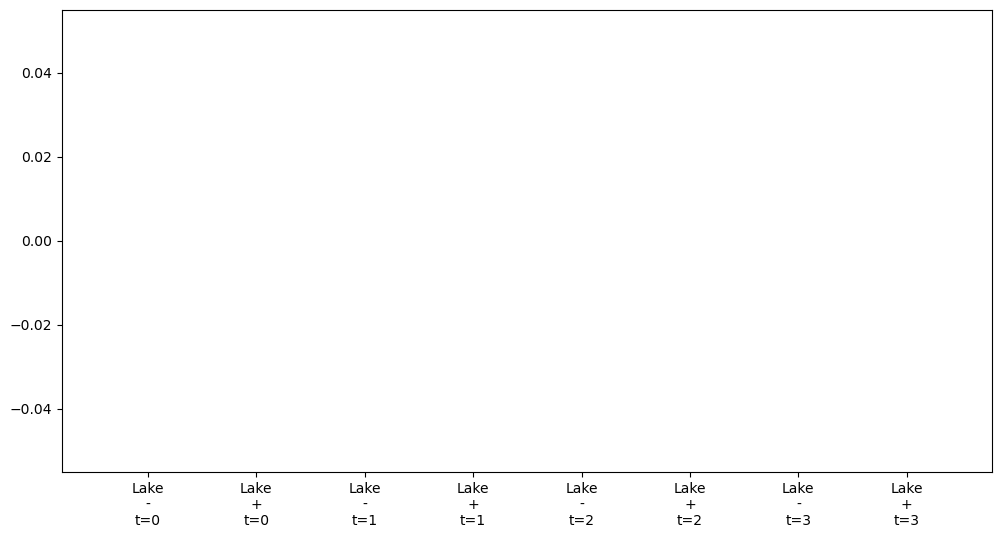

In [6]:
res = linprog(c,A_eq=A_eq,b_eq=b_eq,A_ub=A_ub, b_ub=b_ub,bounds=(0,1))#,method="revised simplex")
print(res)
#print(res.x)
plt.figure(figsize=(12,6))

#power = np.multiply(np.multiply(res.x,non_zero_columns),power_vec)
power = np.multiply(res.x,power_vec)
#print(power)
plt.bar( column_names,power,color=colors)